<a href="https://colab.research.google.com/github/slarkdev/AnomaliesDetection/blob/main/anomaly_detection_lstm_dt3_lesly_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import os
import datetime
import random
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout

from tensorflow.keras.layers import Input

# Fijar semilla aleatoria
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Calcular métricas
def obtenerMetricas(y_test, anomalías):
  accuracy = accuracy_score(y_test, anomalías)
  f1 = f1_score(y_test, anomalías)
  recall = recall_score(y_test, anomalías)
  precision = precision_score(y_test,anomalías)
  roc_auc = roc_auc_score(y_test, anomalías)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-score: {f1:.4f}")
  print(f"AUC-ROC: {roc_auc:.4f}")



In [4]:
def guardar_proyecto(model, y_test, anomalías, history, matriz, nombre_base="modelo_anomalias"):

    # 🕒 Crear carpeta con timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    carpeta = f"/content/drive/MyDrive/3w-dataset-train-test/entrenamientos-2/{nombre_base}_{timestamp}"
    os.makedirs(carpeta, exist_ok=True)

    # 1. Guardar el modelo
    modelo_path = os.path.join(carpeta, f"{nombre_base}.h5")
    model.save(modelo_path)

    # 2. Guardar métricas
    reporte = classification_report(y_test, anomalías)
    acc = accuracy_score(y_test, anomalías)
    f1 = f1_score(y_test, anomalías)
    recall = recall_score(y_test, anomalías)
    precision = precision_score(y_test,anomalías)
    auc = roc_auc_score(y_test, anomalías)

    with open(os.path.join(carpeta, "reporte_metricas.txt"), "w") as f:
        f.write("REPORTE DE CLASIFICACIÓN\n")
        f.write(reporte)
        f.write("\n\nMétricas adicionales:\n")
        f.write(f"Accuracy: {acc:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1-score: {f1:.4f}\n")
        f.write(f"AUC-ROC: {auc:.4f}\n")

    # 3. Guardar historial de entrenamiento
    pd.DataFrame(history.history).to_csv(os.path.join(carpeta, "historial_entrenamiento.csv"), index=False)

    total_anomalias = int(np.sum(y_test))  # Cantidad total de anomalías
    anomalías_predichas = int(np.sum(anomalías.astype(int)))  # Convertir booleanos a enteros

    # Crear gráfico de barras
    plt.bar(["Real Anomalies", "Anomalies Detected"], [total_anomalias, anomalías_predichas], color=['red', 'blue'])

    # Personalizar gráfico
    plt.ylabel("Number of Anomalies")
    plt.title("Comparison of Real vs. Predicted Anomalies")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(carpeta, "grafico_comparison_real_vs_anomalies.png"))
    plt.close()

    # grafico 4 matriz de confusion
    sns.heatmap(matriz, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Normal", "Anomalous"], yticklabels=["Normal", "Anomalous"])
    plt.xlabel("Prediction")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(carpeta, "grafico_confusion_matriz.png"))
    plt.close()


    print(f"✅ Todo guardado exitosamente en la carpeta: {carpeta}")


In [5]:
def crearGraficos(TimeSeries):


  plt.figure(figsize=(8, 3))
  plt.plot(TimeSeries['P-TPT'], label='P-TPT')
  plt.legend();

  plt.figure(figsize=(8, 3))
  plt.plot(TimeSeries['T-TPT'], label='T-TPT')
  plt.legend();

  plt.figure(figsize=(8, 3))
  plt.plot(TimeSeries['P-MON-CKP'], label='P-MON-CKP')
  plt.legend();

  plt.figure(figsize=(8, 3))
  plt.plot(TimeSeries['T-JUS-CKP'], label='T-JUS-CKP')
  plt.legend();

  plt.figure(figsize=(8, 3))
  plt.plot(TimeSeries['P-JUS-CKGL'], label='P-JUS-CKGL')
  plt.legend();

  plt.figure(figsize=(8, 3))
  plt.plot(TimeSeries['class'], label='class')
  plt.legend();


# ** Configuracion y Aplicacion del Modelo **

In [6]:
#Especificar las rutas de los archivos en Google Drive
ruta_dataset0 = "/content/drive/MyDrive/3w-dataset-train-test/dataset-train.csv"

ruta_csv3 = "/content/drive/MyDrive/3w-dataset-train-test/dataset-test-06.csv"

df0 = pd.read_csv(ruta_dataset0, parse_dates=['timestamp'], index_col='timestamp')
# Leer los CSV en DataFrames
df3 = pd.read_csv(ruta_csv3, parse_dates=['timestamp'], index_col='timestamp')


In [7]:
df0

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,class
timestamp,,,,,,
2013-12-11 23:00:15,0.998766,0.668012,0.967624,1.000000,0.591835,0.0
2013-12-11 23:00:16,0.998757,0.667947,0.967581,1.000000,0.591822,0.0
2013-12-11 23:00:17,0.998749,0.667860,0.967538,1.000000,0.591810,0.0
2013-12-11 23:00:18,0.998741,0.667795,0.967495,1.000000,0.591798,0.0
2013-12-11 23:00:19,0.998731,0.667730,0.967452,1.000000,0.591785,0.0
...,...,...,...,...,...,...
2017-02-11 10:18:43,0.068794,0.593010,0.114767,0.032128,0.016705,0.0
2017-02-11 10:18:44,0.068811,0.593075,0.112556,0.031791,0.016705,0.0
2017-02-11 10:18:45,0.068827,0.593162,0.110345,0.031454,0.016705,0.0


In [8]:
df0 = df0[~df0.index.duplicated(keep="first")]

df0

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,class
timestamp,,,,,,
2013-12-11 23:00:15,0.998766,0.668012,0.967624,1.000000,0.591835,0.0
2013-12-11 23:00:16,0.998757,0.667947,0.967581,1.000000,0.591822,0.0
2013-12-11 23:00:17,0.998749,0.667860,0.967538,1.000000,0.591810,0.0
2013-12-11 23:00:18,0.998741,0.667795,0.967495,1.000000,0.591798,0.0
2013-12-11 23:00:19,0.998731,0.667730,0.967452,1.000000,0.591785,0.0
...,...,...,...,...,...,...
2017-02-11 10:18:43,0.068794,0.593010,0.114767,0.032128,0.016705,0.0
2017-02-11 10:18:44,0.068811,0.593075,0.112556,0.031791,0.016705,0.0
2017-02-11 10:18:45,0.068827,0.593162,0.110345,0.031454,0.016705,0.0


In [9]:
inicio = '2014-02-12 17:03:33' # '2014-03-01 15:17:00'
fin = '2014-02-12 23:49:42' #'2014-03-01 18:28:17'

df_anomalo = df3.loc[inicio:fin]

print("Cantidad de registros seleccionados:", len(df_anomalo))
print(df_anomalo['class'].value_counts())
df_anomalo

Cantidad de registros seleccionados: 24131
class
0.0    15018
1.0     9113
Name: count, dtype: int64


,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,class
timestamp,,,,,,
2014-02-12 17:03:33,0.147457,0.356723,0.299044,0.774090,0.875931,0.0
2014-02-12 17:03:34,0.147572,0.357025,0.299044,0.774081,0.875910,0.0
2014-02-12 17:03:35,0.147688,0.357326,0.299044,0.774075,0.875889,0.0
2014-02-12 17:03:36,0.147797,0.357627,0.299044,0.774066,0.875867,0.0
2014-02-12 17:03:37,0.147913,0.357928,0.299044,0.774061,0.875846,0.0
...,...,...,...,...,...,...
2014-02-12 23:49:38,0.530040,0.336245,0.589047,0.655662,0.049450,1.0
2014-02-12 23:49:39,0.530040,0.336094,0.589047,0.655671,0.049432,1.0
2014-02-12 23:49:40,0.530040,0.335793,0.589047,0.655680,0.049416,1.0


In [10]:
# Crear un rango de tiempo completo con intervalos de 1s
fecha_inicio = df_anomalo.index.min()
fecha_fin = df_anomalo.index.max()
rango_tiempo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq="1s")

# Reindexar el DataFrame para que siga la secuencia perfecta de 1s
df_anomalo_reindexado = df_anomalo.reindex(rango_tiempo)

print("Tamaño original:", len(df_anomalo))
print("Tamaño nuevo con frecuencia fija:", len(df_anomalo_reindexado))
df_anomalo = df_anomalo_reindexado
print("Valores faltantes por columna antes del relleno:")
print(df_anomalo.isnull().sum())

df_anomalo["class"].fillna(0, inplace=True)
df_anomalo = df_anomalo.interpolate(method="linear")
print("Valores faltantes por columna después del relleno:")
print(df_anomalo.isnull().sum())
print(df_anomalo['class'].value_counts())

Tamaño original: 24131
Tamaño nuevo con frecuencia fija: 24370
Valores faltantes por columna antes del relleno:
P-TPT         239
T-TPT         239
P-MON-CKP     239
T-JUS-CKP     239
P-JUS-CKGL    239
class         239
dtype: int64
Valores faltantes por columna después del relleno:
P-TPT         0
T-TPT         0
P-MON-CKP     0
T-JUS-CKP     0
P-JUS-CKGL    0
class         0
dtype: int64
class
0.0    15257
1.0     9113
Name: count, dtype: int64


/tmp/ipython-input-10-2640825183.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_anomalo["class"].fillna(0, inplace=True)


In [11]:
inicio = '2017-02-10 03:00:33'
fin = '2017-02-10 16:00:00'

df_normal = df0.loc[inicio:fin]

print("Cantidad de registros seleccionados:", len(df_normal))
print(df_normal['class'].value_counts())
df_normal

Cantidad de registros seleccionados: 46411
class
0.0    46411
Name: count, dtype: int64


,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,class
timestamp,,,,,,
2017-02-10 03:00:33,0.123950,0.500000,0.072765,0.078581,0.015825,0.0
2017-02-10 03:00:34,0.123950,0.500000,0.069811,0.078713,0.015825,0.0
2017-02-10 03:00:35,0.123950,0.500000,0.066857,0.078845,0.015825,0.0
2017-02-10 03:00:36,0.123950,0.500000,0.063903,0.078977,0.015825,0.0
2017-02-10 03:00:37,0.123950,0.500000,0.060949,0.079109,0.015825,0.0
...,...,...,...,...,...,...
2017-02-10 15:59:56,0.095938,0.370064,0.116334,0.062307,0.016293,0.0
2017-02-10 15:59:57,0.095947,0.370086,0.113057,0.062637,0.016293,0.0
2017-02-10 15:59:58,0.095956,0.370086,0.109781,0.062968,0.016293,0.0


In [12]:
# Crear un rango de tiempo completo con intervalos de 1s
fecha_inicio = df_normal.index.min()
fecha_fin = df_normal.index.max()
rango_tiempo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq="1S")

# Reindexar el DataFrame para que siga la secuencia perfecta de 1s
df_normal = df_normal.drop_duplicates()
df_normal_reindexado = df_normal.reindex(rango_tiempo)

print("Tamaño original:", len(df_normal))
print("Tamaño nuevo con frecuencia fija:", len(df_normal_reindexado))
df_normal = df_normal_reindexado
print("Valores faltantes por columna antes del relleno:")
print(df_normal.isnull().sum())

df_normal["class"].fillna(0, inplace=True)
df_normal = df_normal.interpolate(method="linear")
print("Valores faltantes por columna después del relleno:")
print(df_normal.isnull().sum())
print(df_normal['class'].value_counts())

Tamaño original: 46411
Tamaño nuevo con frecuencia fija: 46768
Valores faltantes por columna antes del relleno:
P-TPT         357
T-TPT         357
P-MON-CKP     357
T-JUS-CKP     357
P-JUS-CKGL    357
class         357
dtype: int64
Valores faltantes por columna después del relleno:
P-TPT         0
T-TPT         0
P-MON-CKP     0
T-JUS-CKP     0
P-JUS-CKGL    0
class         0
dtype: int64
class
0.0    46768
Name: count, dtype: int64


/tmp/ipython-input-12-1087916671.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  rango_tiempo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq="1S")
/tmp/ipython-input-12-1087916671.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_normal["class"].fillna(0, inplace=True)


In [13]:
test = df_anomalo
train = df_normal
test.index.name = 'timestamp'
train.index.name= 'timestamp'

In [14]:
train = train.sort_values("timestamp")
test = test.sort_values("timestamp")

print(train['class'].value_counts())
print(test['class'].value_counts())

class
0.0    46768
Name: count, dtype: int64
class
0.0    15257
1.0     9113
Name: count, dtype: int64


In [15]:
columns_names = df3.columns.values
columns_names

array(['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'class'],
      dtype=object)

In [16]:
# Definir las columnas de entrada y salida:
input_columns = ['P-TPT',	'T-TPT','P-MON-CKP', 'T-JUS-CKP','P-JUS-CKGL',]
output_columns = ['class']

In [17]:
# Definir una función para crear secuencias de longitud sequence_length
def create_sequences(data, sequence_length):
 X = []
 y = []
 for i in range(len(data) - sequence_length):
    X.append(data.iloc[i:i+sequence_length][input_columns].values)
    y.append(data.iloc[i+sequence_length][output_columns].values)
 return np.array(X), np.array(y)

In [18]:
VentanaTiempo = 400 # segun tipo de anomalia, Anomalia 01:12 horas, anomalia 02: 5-20 minutos, anomalia 06: 15 minutos

# reshape to [samples, time_steps, n_features]
# Crear secuencias de entrenamiento
X_train, y_train = create_sequences(train, VentanaTiempo)
X_test, y_test = create_sequences(test, VentanaTiempo)

print(X_train.shape)
print(X_test.shape)

(46368, 400, 5)
(23970, 400, 5)


In [108]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Dropout

neuronas = 128
columnas_serie_temporal = 5

# Definí la entrada explícitamente
inputs = Input(shape=(VentanaTiempo, columnas_serie_temporal))

# Bloque LSTM 1
x = LSTM(units=neuronas, activation='relu', return_sequences=True)(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Bloque LSTM 2
x = LSTM(units=64, activation='relu', return_sequences=False)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Densa + normalización
x = Dense(units=32, activation='relu')(x)
x = BatchNormalization()(x)

# Salida sigmoide
outputs = Dense(units=1, activation='sigmoid')(x)

# Crear modelo funcional
model = Model(inputs=inputs, outputs=outputs)

# Compilar
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 400, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 400, 128)       │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 400, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 400, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,025 (472.75 KB)

 Trainable params: 120,577 (471.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [109]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    class_weight = {0: 1.0, 1: 50.0}
)

Epoch 1/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - accuracy: 0.8996 - loss: 0.3136 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 1.0000 - loss: 0.0041 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 1.0000 - loss: 0.0011 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 1.0000 - loss: 4.5032e-04 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 1.0000 - loss: 2.3086e-04 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 1.0000 - loss: 1.3046e-04 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 1.0000 - loss: 7.8060e-05 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 8/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step

# CALCULAMOS LAS ANOMALIAS IDENTIFICADAS POR EL MODELO Y LAS COMPARAMOS CON LAS REALES

In [110]:
from tensorflow.keras.models import Model

# Extrae la penúltima capa (Dense de 32 unidades)
modelo_latente = Model(inputs=model.input, outputs=model.layers[-3].output)

# Extraer embeddings de entrenamiento (solo clase normal)
#X_train_normal = X_train[y_train == 0]
embeddings_train = modelo_latente.predict(X_train)

# Extraer embeddings del conjunto de evaluación
embeddings_eval = modelo_latente.predict(X_test)

1449/1449 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step


In [111]:
import numpy as np
from scipy.spatial.distance import cdist

centroide = np.mean(embeddings_train, axis=0, keepdims=True)
distancias = cdist(embeddings_eval, centroide, metric='euclidean').flatten()

In [117]:
umbral = np.percentile(distancias, 57)  # Por ejemplo
y_pred = (distancias > umbral).astype(int)

Accuracy : 0.8354609929078014
Precision: 0.7507519161734744
Recall   : 0.8491166465488862
F1-score : 0.7969104016477858
AUC-ROC  : 0.8381007611824999
[[12288  2569]
 [ 1375  7738]]
              precision    recall  f1-score   support

         0.0     0.8994    0.8271    0.8617     14857
         1.0     0.7508    0.8491    0.7969      9113

    accuracy                         0.8355     23970
   macro avg     0.8251    0.8381    0.8293     23970
weighted avg     0.8429    0.8355    0.8371     23970



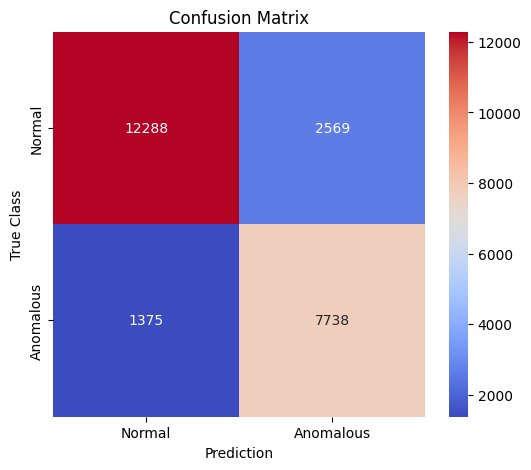

In [118]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred, pos_label=1, average='binary'))
print("AUC-ROC  :", roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Normal", "Anomalous"], yticklabels=["Normal", "Anomalous"])
plt.xlabel("Prediction")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

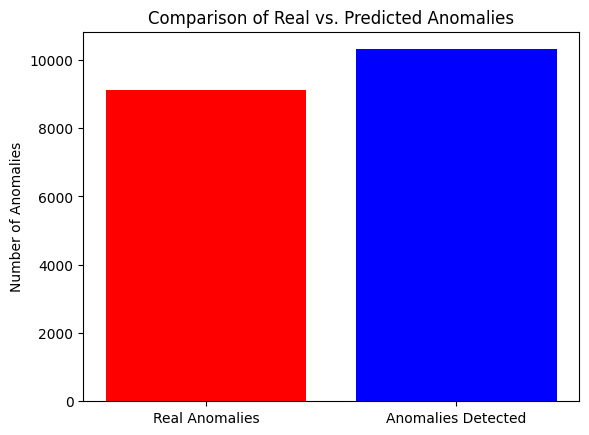

In [119]:
import matplotlib.pyplot as plt

total_anomalias = int(np.sum(y_test))  # Cantidad total de anomalías
anomalías_predichas = int(np.sum(y_pred.astype(int)))  # Convertir booleanos a enteros

# Crear gráfico de barras
plt.bar(["Real Anomalies", "Anomalies Detected"], [total_anomalias, anomalías_predichas], color=['red', 'blue'])

# Personalizar gráfico
plt.ylabel("Number of Anomalies")
plt.title("Comparison of Real vs. Predicted Anomalies")
plt.show()


In [120]:
guardar_proyecto(model, y_test, y_pred, history, cm, nombre_base='lstm_ocl_dt3_ws_400_bs_64_e_20_acc_8357')


/tmp/ipython-input-4-2695163730.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


✅ Todo guardado exitosamente en la carpeta: /content/drive/MyDrive/3w-dataset-train-test/entrenamientos-2/lstm_ocl_dt3_ws_400_bs_64_e_20_acc_8357_20250625_221435
